# Classifying Tumor vs. Normal

In this notebook I build models that takes RNAseq profiles from matched normal-tumor pairs and classifies the sample as Normal or Tumor. I try to do this task using two different subsets of the feature space: firstly using the complete gene expression data available, and later using only the expressions of protein encoding genes and compare results. 

Before starting the analysis I preprocess the data by splitting it into training (75%) and testing sets. Later, I use the scikit-learn standard scaler to scale the data. 

I try the five traditional ML algorithms in the following order: 
* k-nearest neighbors
* Support Vector Machine
* Naive Bayes 
* Decision Tree
* Random Forest

Out of these algorithms, the support vector classifier (SVC) with linear kernel performs the best with 97.2% cross-validated accuracy for both datasets. SVC is closely followed by the Random Forest algorithm at ~96%. I use the dataset with the protein coding genes to visualize the feature importances of the Random Forest as well as the coefficients of the SVC, displaying the top 10 genes that influenced the decision-making of these models. 

Next, I use the SVC and RF model trained on the full training set to make predictions on the holdout set where they achieve accuracy scores of 96.5% and 95.14% respectively. 

Later I build a deep learning classifier for the same task and †est the deep learning classifer with different training sizes. The performance of the model starts at 100 when we use 95% of the data to train the model, and starts to decrease as it gets fewer and fewer data to train on. Later I use this size to train the model on all training samples and validate it using the hold out set. The final deep learning model achieves an accuracy score of 95.43%. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
# from tpot import TPOTClassifier
# from xgboost import XGBClassifier

# Load Data

In [7]:
nt_all = pd.read_csv('data/nt.all.csv')

In [2]:
nt_coding = pd.read_csv('data/nt.coding.csv')

In [9]:
nt_all.head()

,Type,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,...,ENSGR0000263980.4,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1
0,0,150265.480539,4327.845865,713909.310619,59794.653619,15491.855614,47067.296272,184497.123078,303028.753262,101488.999785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,913228.181789,2326.284691,828500.414250,50302.756694,30476.958826,119788.855372,323720.579478,232881.114861,204409.893911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,359658.934678,228971.470681,483960.593070,69872.468893,16789.274018,76493.522968,735607.786830,512566.438580,108147.729799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,135634.675596,0.000000,748257.784782,75504.611322,27890.960291,55978.045025,118630.138127,710455.556708,250891.525261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,81454.831124,177.310309,363281.940134,45622.048124,8563.609511,687378.578868,143523.388792,459940.275222,45368.853671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
nt_all.shape

(1400, 60484)

In [11]:
nt_coding.head()

,Type,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,...,ENSG00000269699.4,ENSG00000269711.1,ENSG00000269741.4,ENSG00000269749.1,ENSG00000269755.1,ENSG00000269846.1,ENSG00000269855.2,ENSG00000269858.4,ENSG00000269881.1,ENSG00000269883.1
0,0,150265.480539,4327.845865,713909.310619,59794.653619,15491.855614,47067.296272,184497.123078,303028.753262,101488.999785,...,491.731252,0.000000,0.000000,0.000000,5530.025272,999.688930,2815.285593,80163.084910,6837.301541,200.744219
1,0,913228.181789,2326.284691,828500.414250,50302.756694,30476.958826,119788.855372,323720.579478,232881.114861,204409.893911,...,146.840679,0.000000,44133.486358,902.703869,0.000000,298.526889,106768.895783,55490.416008,742.455814,0.000000
2,0,359658.934678,228971.470681,483960.593070,69872.468893,16789.274018,76493.522968,735607.786830,512566.438580,108147.729799,...,427.189045,0.000000,0.000000,0.000000,3603.136170,217.118679,1528.603224,62677.148077,4319.906344,0.000000
3,1,135634.675596,0.000000,748257.784782,75504.611322,27890.960291,55978.045025,118630.138127,710455.556708,250891.525261,...,322.662334,0.000000,946.120078,661.189483,1555.144652,218.657354,16318.022871,54779.302382,5030.289480,0.000000
4,0,81454.831124,177.310309,363281.940134,45622.048124,8563.609511,687378.578868,143523.388792,459940.275222,45368.853671,...,201.460549,23513.583319,0.000000,619.239908,970.985025,0.000000,2595.178159,103692.697035,1909.921482,0.000000


In [12]:
nt_coding.shape

(1400, 19562)

# Pre-processing

## Seperate labels and features

In [3]:
y_coding = nt_coding['Type']
X_coding = nt_coding.drop('Type', axis=1)

In [14]:
y_all = nt_all['Type']
X_all = nt_all.drop('Type', axis=1)

## Split into training and validation sets

In [9]:
X_coding_train, X_coding_test, y_coding_train, y_coding_test = train_test_split(X_coding, y_coding, 
                                                    test_size=.25, random_state=1)

In [16]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, 
                                                    test_size=.25, random_state=1)

In [10]:
scaler_coding = StandardScaler()
scaler_all = StandardScaler()

X_coding_train = scaler_coding.fit_transform(X_coding_train)
X_coding_test = scaler_coding.transform(X_coding_test)

X_all_train = scaler_all.fit_transform(X_all_train)
X_all_test = scaler_all.transform(X_all_test)

# Classification

* k-nearest neighbors
* Support Vector Machine (SVM)
* Naive Bayes
* Decision Tree
* Random Forest

In [35]:
def display_cv_metrics(metrics):
    for k, v in metrics.items():
        print(f'{k}: {np.round(v.mean(), 3)}')

In [36]:
metrics = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

In [38]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

## k-nearest neighbors

In [40]:
knn = KNeighborsClassifier()

In [41]:
knn_scores_coding = cross_validate(estimator=knn, 
                              X=X_coding_train,
                              y=y_coding_train,
                              scoring=metrics,
                              cv=skf)

In [42]:
knn_scores_all = cross_validate(estimator=knn, 
                              X=X_all_train,
                              y=y_all_train,
                              scoring=metrics,
                              cv=skf)

In [43]:
display_cv_metrics(knn_scores_coding)

fit_time: 0.81
score_time: 11.025
test_accuracy: 0.891
test_f1: 0.882
test_precision: 0.982
test_recall: 0.802
test_roc_auc: 0.966


In [44]:
display_cv_metrics(knn_scores_all)

fit_time: 3.364
score_time: 32.006
test_accuracy: 0.841
test_f1: 0.817
test_precision: 0.984
test_recall: 0.7
test_roc_auc: 0.956


## Support Vector Machine

In [97]:
svc = SVC(kernel='linear')

In [98]:
svc_scores_coding = cross_validate(estimator=svc, 
                              X=X_coding_train,
                              y=y_coding_train,
                              scoring=metrics,
                              cv=skf)

In [99]:
svc_scores_all = cross_validate(estimator=svc, 
                              X=X_all_train,
                              y=y_all_train,
                              scoring=metrics,
                              cv=skf)

In [100]:
display_cv_metrics(svc_scores_coding)

fit_time: 4.691
score_time: 2.066
test_accuracy: 0.972
test_f1: 0.973
test_precision: 0.98
test_recall: 0.966
test_roc_auc: 0.992


In [101]:
display_cv_metrics(svc_scores_all)

fit_time: 20.542
score_time: 9.303
test_accuracy: 0.972
test_f1: 0.973
test_precision: 0.981
test_recall: 0.965
test_roc_auc: 0.993


## Naive Bayes Classifier

In [50]:
nb = GaussianNB()

In [51]:
nb_scores_coding = cross_validate(estimator=nb, 
                              X=X_coding_train,
                              y=y_coding_train,
                              scoring=metrics,
                              cv=skf)

In [73]:
nb_scores_all = cross_validate(estimator=nb, 
                              X=X_all_train,
                              y=y_all_train,
                              scoring=metrics,
                              cv=skf)

In [53]:
display_cv_metrics(nb_scores_coding)

fit_time: 0.444
score_time: 0.095
test_accuracy: 0.918
test_f1: 0.921
test_precision: 0.91
test_recall: 0.933
test_roc_auc: 0.922


In [74]:
display_cv_metrics(nb_scores_all)

fit_time: 2.445
score_time: 0.309
test_accuracy: 0.657
test_f1: 0.708
test_precision: 0.629
test_recall: 0.812
test_roc_auc: 0.654


## Decision Tree Classifier

In [55]:
dt = DecisionTreeClassifier(random_state=1)

In [56]:
dt_scores_coding = cross_validate(estimator=dt, 
                              X=X_coding_train,
                              y=y_coding_train,
                              scoring=metrics,
                              cv=skf)

In [57]:
dt_scores_all = cross_validate(estimator=dt, 
                              X=X_all_train,
                              y=y_all_train,
                              scoring=metrics,
                              cv=skf)

In [58]:
display_cv_metrics(dt_scores_coding)

fit_time: 6.907
score_time: 0.02
test_accuracy: 0.909
test_f1: 0.91
test_precision: 0.914
test_recall: 0.907
test_roc_auc: 0.909


In [59]:
display_cv_metrics(dt_scores_all)

fit_time: 14.78
score_time: 0.06
test_accuracy: 0.905
test_f1: 0.906
test_precision: 0.913
test_recall: 0.899
test_roc_auc: 0.905


## Random Forest Classifier

In [60]:
rf = RandomForestClassifier(max_depth=3, random_state=1)

In [61]:
rf_scores_coding = cross_validate(estimator=rf, 
                              X=X_coding_train,
                              y=y_coding_train,
                              scoring=metrics,
                              cv=skf)

In [62]:
rf_scores_all = cross_validate(estimator=rf, 
                              X=X_all_train,
                              y=y_all_train,
                              scoring=metrics,
                              cv=skf)

In [63]:
display_cv_metrics(rf_scores_coding)

fit_time: 1.971
score_time: 0.037
test_accuracy: 0.957
test_f1: 0.958
test_precision: 0.956
test_recall: 0.961
test_roc_auc: 0.991


In [64]:
display_cv_metrics(rf_scores_all)

fit_time: 3.422
score_time: 0.067
test_accuracy: 0.956
test_f1: 0.957
test_precision: 0.961
test_recall: 0.953
test_roc_auc: 0.992


## Selecting the best performer

In [65]:
scores_all = [knn_scores_all, svc_scores_all, nb_scores_all, 
              dt_scores_all, rf_scores_all]

scores_coding = [knn_scores_coding, svc_scores_coding, 
                 nb_scores_coding, dt_scores_coding, rf_scores_coding]

names = ['K-Nearest Neighbors', 'Support Vector Classifier', 'Naive Bayes Classifier', 
        'Decision Tree Classifier', 'Random Forest Classifier']

In [66]:
for score in scores_all:
    for k, v in score.items():
        score[k] = v.mean()

In [67]:
for score in scores_coding:
    for k, v in score.items():
        score[k] = v.mean()

### For all genes

In [109]:
pd.DataFrame(scores_all, index=names)

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc
K-Nearest Neighbors,3.364365,32.006083,0.840952,0.816745,0.984169,0.699533,0.955647
Support Vector Classifier,20.541505,9.303161,0.972381,0.972630,0.981336,0.964521,0.992669
Naive Bayes Classifier,2.191593,0.295318,0.657143,0.707806,0.629284,0.811578,0.653981
Decision Tree Classifier,14.779774,0.060417,0.904762,0.905943,0.912786,0.899290,0.904899
Random Forest Classifier,3.422036,0.067356,0.956190,0.956934,0.960781,0.953340,0.992069


### For only protein-coding genes

In [110]:
pd.DataFrame(scores_coding, index=names)

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc
K-Nearest Neighbors,0.809870,11.025419,0.891429,0.882157,0.981738,0.802077,0.965718
Support Vector Classifier,4.690663,2.065730,0.972381,0.972663,0.979575,0.966390,0.992378
Naive Bayes Classifier,0.443795,0.095060,0.918095,0.920576,0.909718,0.932866,0.921958
Decision Tree Classifier,6.906948,0.019686,0.908571,0.910091,0.913765,0.906819,0.908616
Random Forest Classifier,1.971109,0.036887,0.957143,0.958180,0.956230,0.960782,0.991180


## Important RNA-sequences in Classifying Tumor

Support Vector Classifier with linear kernel seems to have a slightly higher cross validated ROC AUC and accuracy scores across both datasets, closely followed by the Random Forest Classifier.

Dataset with just the protein-coding genes seems to be performing as well as the full dataset despite having fewer features. We will compute Random Forest feature importances based on mean decrease in impurity and display the first 10 genes that are the best predictors of tumor.

### Random Forest Feature Importances

In [76]:
rf.fit(X_all_train, y_all_train)

RandomForestClassifier(max_depth=3, random_state=1)

In [77]:
importances = rf.feature_importances_

In [78]:
feature_names = list(nt_coding.columns[1:])

In [79]:
importance_df = pd.DataFrame(zip(feature_names, importances), columns=['gene', 'importance'])

#### Top 20 genes for predicting tumor

In [191]:
top_20_rf = importance_df.sort_values('importance', ascending=False).head(20)

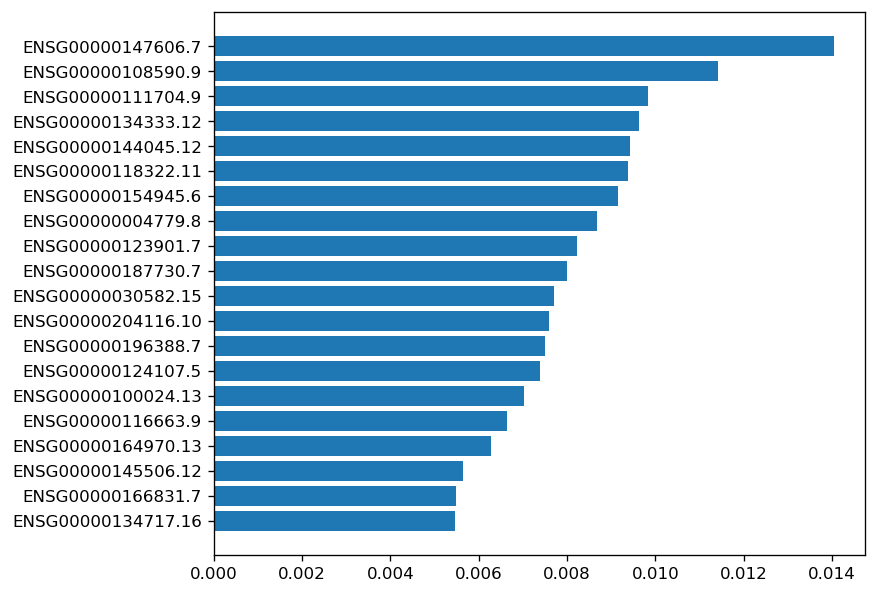

In [194]:
plt.figure(figsize=(7, 6), dpi=120)
plt.barh(y=top_20_rf.gene[::-1], width=top_20_rf.importance[::-1]);

### SVC Feature Importances

In [111]:
svc = SVC(kernel='linear')
svc.fit(X_all_train, y_all_train)

SVC(kernel='linear')

In [175]:
names, imp = zip(*sorted(zip(nt_all.columns[1:], svc.coef_[0]), key=lambda x: abs(x[1])))

Highest coefficients where higher absolute value means more influence on the decision of the classifier:

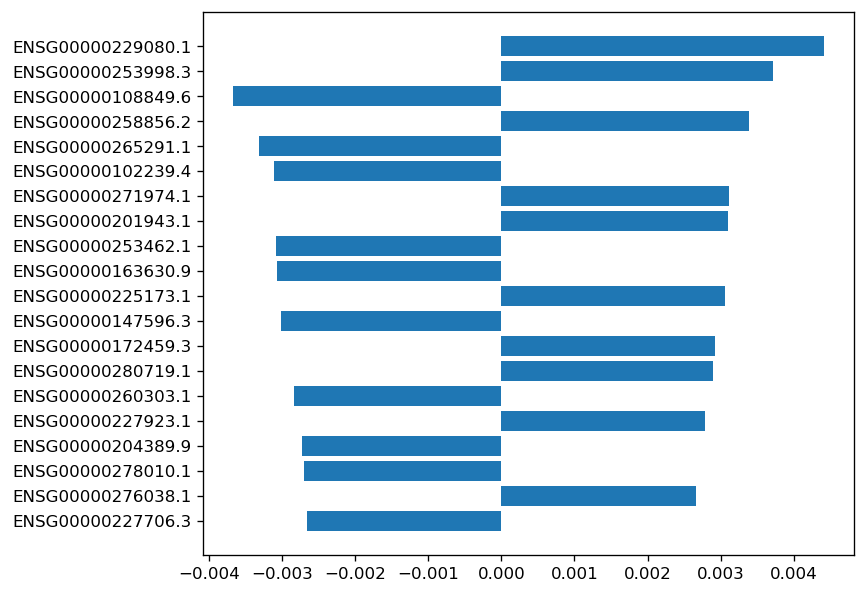

In [198]:
plt.figure(figsize=(7, 6), dpi=120)
plt.barh(y=names[-20:], width=imp[-20:]);

Check to see if any common features for SVC and Random Forest in the top 20:

In [206]:
set(names[-20:]) & set(top_20_rf.gene)

set()

Nope. 

## Confusion matrix with the predictions on the holdout set

### Random Forest

In [210]:
y_all_pred = rf.predict(X_all_test)

In [211]:
cf_matrix = confusion_matrix(y_all_test, y_all_pred, normalize='true')

In [213]:
test_accuracy = (y_all_pred == y_all_test).sum() / len(y_all_test)
print(f"Test accuracy is {test_accuracy * 100}%")

Test accuracy is 95.14285714285714%


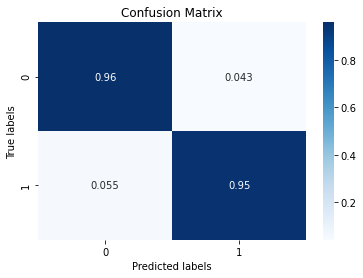

In [214]:
ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

### Support Vector Machine

In [215]:
y_all_pred = svc.predict(X_all_test)

In [216]:
cf_matrix = confusion_matrix(y_all_test, y_all_pred, normalize='true')

In [217]:
test_accuracy = (y_all_pred == y_all_test).sum() / len(y_all_test)
print(f"Test accuracy is {test_accuracy * 100}%")

Test accuracy is 96.57142857142857%


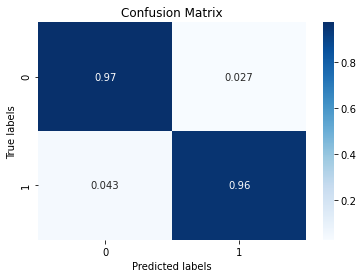

In [218]:
ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

# Deep Learning Classifier

In [6]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

In [25]:
input_layer = Input(shape=(19561,))
# dense = Dense(8192, activation='relu')(input_layer)
# dense = Dense(2048, activation='relu')(dense)
# dense = Dense(512, activation='relu')(dense)
dense = Dense(128, activation='relu')(input_layer)
dense = Dense(32, activation='relu')(dense)
dense = Dense(8, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(input_layer, output)
random_weights = model.get_weights()

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

In [27]:
test_sizes = np.arange(0.05, 0.8, 0.05)
learning_dict = {'Test sizes': test_sizes, 
                'Accuracy': [],
                'Loss': [], 
                'AUC': []}

for size in test_sizes:
    model.set_weights(random_weights)
    X_coding_train, X_coding_test, y_coding_train, y_coding_test = train_test_split(X_coding, y_coding, 
                                                        test_size=size, random_state=1)
    scaler = StandardScaler()
    X_coding_train = scaler.fit_transform(X_coding_train)
    X_coding_test = scaler.transform(X_coding_test)
    
    model.fit(X_coding_train, y_coding_train, epochs=20, 
       batch_size=100)
    loss, accuracy, auc = model.evaluate(X_coding_test, y_coding_test, verbose=2)
    learning_dict['Loss'].append(loss)
    learning_dict['Accuracy'].append(accuracy)
    learning_dict['AUC'].append(auc)

Epoch 1/20
14/14 [==============================] - 1s 10ms/step - loss: 0.5456 - accuracy: 0.8175 - auc: 0.8812
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0640 - accuracy: 0.9820 - auc: 0.9960
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0718 - accuracy: 0.9793 - auc: 0.9956
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0225 - accuracy: 0.9908 - auc: 0.9997
Epoch 5/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0172 - accuracy: 0.9934 - auc: 0.9998
Epoch 6/20
14/14 [==============================] - 0s 11ms/step - loss: 0.0105 - accuracy: 0.9962 - auc: 0.9999
Epoch 7/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0196 - accuracy: 0.9961 - auc: 0.9983
Epoch 8/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0083 - accuracy: 0.9972 - auc: 1.0000
Epoch 9/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0129 - accuracy: 0.99

Epoch 1/20
9/9 [==============================] - 0s 13ms/step - loss: 0.5152 - accuracy: 0.8750 - auc: 0.9474
Epoch 2/20
9/9 [==============================] - 0s 12ms/step - loss: 0.1908 - accuracy: 0.9607 - auc: 0.9891
Epoch 3/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0899 - accuracy: 0.9762 - auc: 0.9935
Epoch 4/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0545 - accuracy: 0.9893 - auc: 0.9960
Epoch 5/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0286 - accuracy: 0.9952 - auc: 0.9976
Epoch 6/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0100 - accuracy: 0.9976 - auc: 0.9999
Epoch 7/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0223 - accuracy: 0.9952 - auc: 0.9988
Epoch 8/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.9988 - auc: 1.0000
Epoch 9/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0242 - accuracy: 0.9976 - auc: 0.9988
E

4/4 [==============================] - 0s 11ms/step - loss: 0.1069 - accuracy: 0.9799 - auc: 0.9927
Epoch 3/20
4/4 [==============================] - 0s 12ms/step - loss: 0.0257 - accuracy: 0.9885 - auc: 0.9996
Epoch 4/20
4/4 [==============================] - 0s 12ms/step - loss: 0.0220 - accuracy: 0.9885 - auc: 0.9997
Epoch 5/20
4/4 [==============================] - 0s 12ms/step - loss: 0.0165 - accuracy: 0.9943 - auc: 0.9999
Epoch 6/20
4/4 [==============================] - 0s 13ms/step - loss: 0.0235 - accuracy: 0.9914 - auc: 0.9999
Epoch 7/20
4/4 [==============================] - 0s 13ms/step - loss: 0.0045 - accuracy: 0.9971 - auc: 1.0000
Epoch 8/20
4/4 [==============================] - 0s 13ms/step - loss: 0.0143 - accuracy: 0.9943 - auc: 0.9999
Epoch 9/20
4/4 [==============================] - 0s 13ms/step - loss: 0.0046 - accuracy: 0.9971 - auc: 1.0000
Epoch 10/20
4/4 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.9971 - auc: 1.0000
Epoch 11/20

### Learning Curve

In [28]:
learning_df = pd.DataFrame(learning_dict)
learning_df

,Test sizes,Accuracy,Loss,AUC
0,0.05,1.000000,0.010854,1.000000
1,0.10,0.978571,0.295458,0.985463
2,0.15,0.981043,0.258320,0.984997
3,0.20,0.967857,0.560612,0.973615
4,0.25,0.971429,0.592794,0.978167
5,0.30,0.952381,3.607821,0.967559
6,0.35,0.951120,1.799700,0.969384
7,0.40,0.957143,2.937108,0.973633
8,0.45,0.960317,1.029379,0.971491
9,0.50,0.970000,2.322681,0.977214


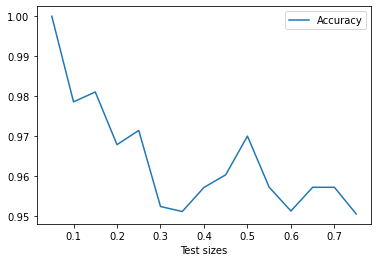

In [29]:
learning_df[['Test sizes', 'Accuracy']].plot(x='Test sizes');

Test accuracy gradually decreases as we decrease the size of the training data. When we use 95% of the data to train the model, test accuracy reaches 100% which means we are predicting every single sample in the testing set correctly. 

In [30]:
model.set_weights(random_weights)
X_coding_train, X_coding_test, y_coding_train, y_coding_test = train_test_split(X_coding, y_coding, 
                                                        test_size=.25, random_state=1)
scaler = StandardScaler()
X_coding_train = scaler.fit_transform(X_coding_train)
X_coding_test = scaler.transform(X_coding_test)

model.fit(X_coding_train, y_coding_train, epochs=20, 
       batch_size=100)

Epoch 1/20
11/11 [==============================] - 0s 14ms/step - loss: 0.3443 - accuracy: 0.8829 - auc: 0.9566
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 0.2266 - accuracy: 0.9657 - auc: 0.9825
Epoch 3/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1101 - accuracy: 0.9829 - auc: 0.9934
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0567 - accuracy: 0.9914 - auc: 0.9976
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 0.0456 - accuracy: 0.9933 - auc: 0.9987
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 0.0119 - accuracy: 0.9962 - auc: 0.9998
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 0.0065 - accuracy: 0.9971 - auc: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.9990 - auc: 1.0000
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.99

### Confusion Matrix for the Deep Learning Classifier

Test accuracy is 95.42857142857143%


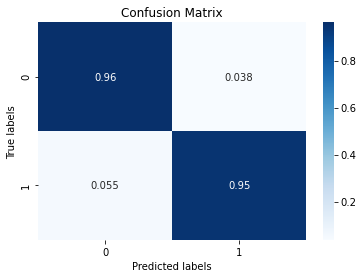

In [32]:
y_coding_pred = (model.predict(X_coding_test) > .5).reshape(350)

cf_matrix = confusion_matrix(y_coding_test, y_coding_pred, normalize='true')

test_accuracy = (y_coding_pred == y_coding_test).sum() / len(y_coding_test)
print(f"Test accuracy is {test_accuracy * 100}%")

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

Slightly different accuracy score.